Using device: cpu
✅ Paths set successfully!
Train folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Train
Validation folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Validation
Test folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Test
Epoch [1/10] | Train Acc: 0.621 | Val Acc: 0.753
Epoch [2/10] | Train Acc: 0.761 | Val Acc: 0.817
Epoch [3/10] | Train Acc: 0.802 | Val Acc: 0.731
Epoch [4/10] | Train Acc: 0.803 | Val Acc: 0.791
Epoch [5/10] | Train Acc: 0.813 | Val Acc: 0.849
Epoch [6/10] | Train Acc: 0.813 | Val Acc: 0.836
Epoch [7/10] | Train Acc: 0.826 | Val Acc: 0.846
Epoch [8/10] | Train Acc: 0.840 | Val Acc: 0.856
Epoch [9/10] | Train Acc: 0.846 | Val Acc: 0.847
Epoch [10/10] | Train Acc: 0.841 | Val Acc: 0.850


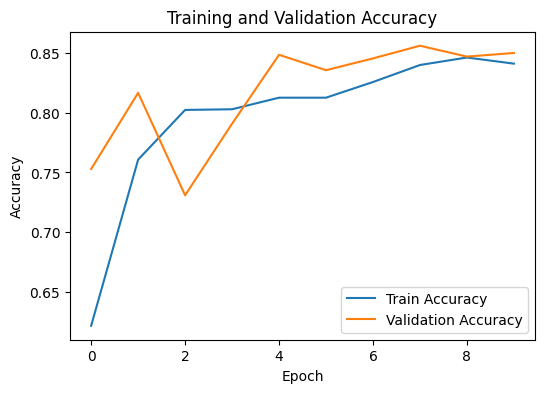


✅ Final Test Accuracy: 57.18%

Confusion Matrix:
 [[232 632]
 [108 756]]

Classification Report:
               precision    recall  f1-score   support

        Fake       0.68      0.27      0.39       864
        Real       0.54      0.88      0.67       864

    accuracy                           0.57      1728
   macro avg       0.61      0.57      0.53      1728
weighted avg       0.61      0.57      0.53      1728



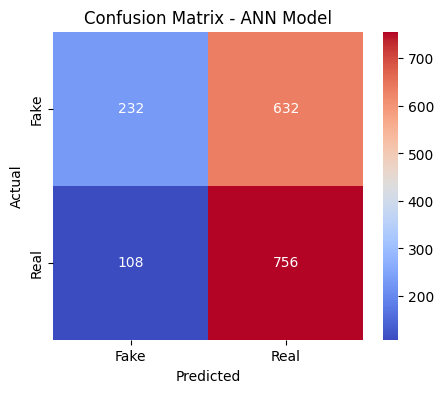

In [6]:
# =====================================================
# Deepfake Detection using ANN - PyTorch (Kaggle Ready)
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# =====================================================
# 0️⃣ Device Setup
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =====================================================
# 1️⃣ Dataset Setup
# =====================================================
dataset_dir = "/kaggle/input/dlproject/Trim_dataset/Dataset"
train_dir = os.path.join(dataset_dir, "Train")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Test")

print("✅ Paths set successfully!")
print("Train folder:", train_dir)
print("Validation folder:", val_dir)
print("Test folder:", test_dir)

# =====================================================
# 2️⃣ Data Preprocessing
# =====================================================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# =====================================================
# 3️⃣ ANN Model Definition
# =====================================================
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*128*3, 512)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.drop1(x)
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = ANNModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =====================================================
# 4️⃣ Training Loop
# =====================================================
num_epochs = 10
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    train_acc.append(acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {acc:.3f} | Val Acc: {val_accuracy:.3f}")

# =====================================================
# 5️⃣ Plot Accuracy Curve
# =====================================================
plt.figure(figsize=(6,4))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# =====================================================
# 6️⃣ Test Evaluation
# =====================================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_accuracy = (y_true == y_pred).mean()
print(f"\n✅ Final Test Accuracy: {test_accuracy*100:.2f}%")

# =====================================================
# 7️⃣ Confusion Matrix
# =====================================================
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix - ANN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


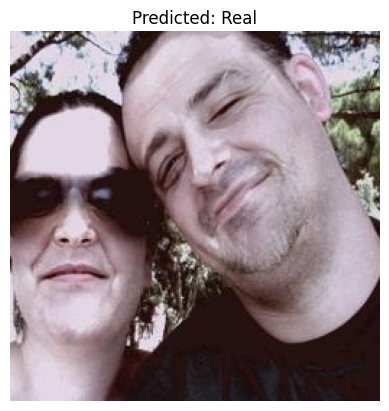

In [15]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# ✅ Path to your custom image
image_path = "/kaggle/input/dlproject/Trim_dataset/Dataset/Test/Fake/fake_119.jpg"  # change to your image path

# 1️⃣ Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # same as training
    transforms.ToTensor()
])

img = Image.open(image_path).convert("RGB")  # ensure 3 channels
img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension

# 2️⃣ Model prediction
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = (output > 0.5).float().item()

# 3️⃣ Map prediction to class names
classes = train_data.classes  # ["Fake", "Real"]
predicted_label = classes[int(pred)]

# 4️⃣ Show image with prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
# =====================================================
# Deepfake Detection using CNN - PyTorch (Kaggle Ready)
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# =====================================================
# 0️⃣ Device Setup
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =====================================================
# 1️⃣ Dataset Setup
# =====================================================
dataset_dir = "/kaggle/input/dlproject/Trim_dataset/Dataset"
train_dir = os.path.join(dataset_dir, "Train")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Test")

print("✅ Paths set successfully!")
print("Train folder:", train_dir)
print("Validation folder:", val_dir)
print("Test folder:", test_dir)

# =====================================================
# 2️⃣ Data Preprocessing + Augmentation
# =====================================================
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# =====================================================
# 3️⃣ CNN Model Definition
# =====================================================
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128*16*16, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

model = CNNModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =====================================================
# 4️⃣ Training Loop
# =====================================================
num_epochs = 15
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    train_acc.append(acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {acc:.3f} | Val Acc: {val_accuracy:.3f}")

# =====================================================
# 5️⃣ Plot Accuracy Curve
# =====================================================
plt.figure(figsize=(6,4))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# =====================================================
# 6️⃣ Test Evaluation
# =====================================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_accuracy = (y_true == y_pred).mean()
print(f"\n✅ Final Test Accuracy: {test_accuracy*100:.2f}%")

# =====================================================
# 7️⃣ Confusion Matrix
# =====================================================
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =====================================================
# 8️⃣ Single Custom Image Prediction
# =====================================================
from PIL import Image
image_path = "/kaggle/working/custom_image.jpg"  # Replace with your image path

custom_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

img = Image.open(image_path).convert("RGB")
img_tensor = custom_transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = (output > 0.5).float().item()

classes = train_data.classes  # ["Fake", "Real"]
predicted_label = classes[int(pred)]

plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


Using device: cpu
✅ Paths set successfully!
Train folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Train
Validation folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Validation
Test folder: /kaggle/input/dlproject/Trim_dataset/Dataset/Test
Epoch [1/15] | Train Acc: 0.666 | Val Acc: 0.820
Epoch [2/15] | Train Acc: 0.827 | Val Acc: 0.831
Epoch [3/15] | Train Acc: 0.858 | Val Acc: 0.802
Epoch [4/15] | Train Acc: 0.861 | Val Acc: 0.882
Epoch [5/15] | Train Acc: 0.872 | Val Acc: 0.837
